# Post processing notebook 

### This notebook import the visualisation functions from the main library and loads the state and meta file and allows you to modify the appearance of the output of Affinity-VAE


In [3]:
import torch 
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed, Dropdown
from avae.vis import latent_embed_plot_umap, latent_embed_plot_tsne
from avae.utils import colour_per_class
import warnings
warnings.filterwarnings('ignore')


### The following functions take in the path of the meta and the state file respectively and load them 

In [7]:
def load_meta(meta_fn, device="cpu"):
    meta_df = pd.read_pickle(meta_fn)

    mu = meta_df[
        [col for col in meta_df.columns if col.startswith("lat")]
    ].to_numpy()  # Assuming the column name for latent variables is 'latent'
    
    labels = meta_df["id"]

    pose = meta_df[
        [col for col in meta_df.columns if col.startswith("pos")]
    ].to_numpy()
    
    std = meta_df[
        [col for col in meta_df.columns if col.startswith("std")]
    ].to_numpy()
    
    #### why is there an 0.5 attached to beginning of each std array so that the size is 17?
    std = std[:,1:]
    
    z =  np.random.randn(*std.shape)  * std + mu
    
    return mu, pose, labels, std, z
    

def load_model(model_fn, device="cpu"):
    checkpoint = torch.load(model_fn, map_location=torch.device(device))
    model = checkpoint["model_class_object"]
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    return model

# Enter the path for the saved model and corresponding meta file 

In [10]:
model_fn = '/Users/mfamili/Baskerville/marji/single_particle/g2_b4_p1_l3/states/avae_09_44_30_01_2024_E1539_16_1.pt'
meta_fn = '/Users/mfamili/Baskerville/marji/single_particle/g2_b4_p1_l3/states/meta_09_44_30_01_2024_E1539_16_1.pkl'


# Grab the Information in the meta file and load the model
### From the meta file 
1. `mu`: mean of the latents ($\mu$)
2. `std`: standard deviation of the latents ($\sigma$)
3. `p`: $pose$
4. `labels`: class labels
5. `z`: sampled latent ($z$) 
### model loaded to `model`

In [11]:
mu, p, labels, std, z = load_meta(meta_fn)
model =load_model(model_fn)

# Configure latent embedding:
#### select the following to plot the UMAP embedding of the latent space : 
1. `select_function`: The drop down list allows you to choose between UMAP and TSNE for your dimentionality reduction of the latent embeddings. 
2. `rs` : This slider sets the random state for the UMAP plot.
3. `perplexity`: This slider sets the perplexity for the TSNE plot.
4. `Data Type`: This drop down list allows you to select which variable to plot (`z` : stochastic sample of latent space, `mu`: the mean of the latent space, `p`: Pose space)
5. `class_list_order`: ordeer of the classes, this should help with consistent colouring of the plots 
6. `marker_size`: adjust the size of markers for each data point to have the desired plot appearence.

In [13]:
# Define the slider widget
class_list_order = list("aebd2ziju")
random_state_slider = IntSlider(min=0, max=100, step=1, value=42)
perplexity_slider = IntSlider(min=2, max=100, step=1, value=40, description='Perplexity')

# Define the dropdown widget for selecting the function
function_selector = Dropdown(options=['latent_embed_plot_umap', 'latent_embed_plot_tsne'],
                             value='latent_embed_plot_umap', description='Select Function')

# Use the interact function with both widgets
interact(lambda function, data_type, rs, perplexity: (latent_embed_plot_umap(xs=z if data_type == 'z' and function == 'latent_embed_plot_umap' else (mu if data_type == 'mu' else p),
                                                                  ys=labels, classes=class_list_order,  rs=rs, marker_size=104, display=True)
                                          if function == 'latent_embed_plot_umap'
                                          else latent_embed_plot_tsne(xs=z if data_type == 'z' and function == 'latent_embed_plot_tsne' else mu,
                                                                      ys=labels, perplexity=perplexity, display=True)),
         function=function_selector,
         data_type=Dropdown(options=['z', 'mu', 'p'], value='z', description='Data Type'),
         rs=random_state_slider,
         perplexity = perplexity_slider)


interactive(children=(Dropdown(description='Select Function', options=('latent_embed_plot_umap', 'latent_embed…

<function __main__.<lambda>(function, data_type, rs, perplexity)>

## Creating new latent interpolation plots

1. choose the size of your input images : `dsize`

2. choose the plot interpolation steps via the slider : `num_int`

note that everytime you drag the `num_int` slider the plot corners change, if you would like to start from a given number of interpolation steps change the value of `init_interpolation_steps` in the code cell below. 

In [68]:
from avae.vis import latent_4enc_interpolate_plot

dsize = [64,64]
init_interpolation_steps = 10

number_interpolation = IntSlider(min=2, max=20, step=1, value=init_interpolation_steps)
interact(lambda num_int: latent_4enc_interpolate_plot(dsize= dsize, xs= torch.from_numpy(z).to(dtype=torch.float), 
                             ys= labels, vae = model ,device = "cpu", plots_config = f"1,{num_int}", 
                             poses = p, display = True),num_int=number_interpolation)

interactive(children=(IntSlider(value=10, description='num_int', max=20, min=2), Output()), _dom_classes=('wid…

<function __main__.<lambda>(num_int)>

## Creating new pose interpolation plots
1. choose the size of your input images : `dsize`
2. choose the plot interpolation steps via the slider : `number_of_samples`
3. choose the classes you would like the interpolation to be generated for via the variable : `pose_vis_class`



In [69]:
from avae.vis import pose_class_disentanglement_plot

dsize= [64,64]
pose_vis_class = "z,2"

num_int = IntSlider(min=2, max=20, step=1, value=8)
interact(lambda number_of_samples:pose_class_disentanglement_plot(dsize= dsize, x= torch.from_numpy(z).to(dtype=torch.float), 
                                y= labels, pose_vis_class=pose_vis_class, poses = p, vae = model,
                                device = "cpu", number_of_samples = number_of_samples ,display = True), number_of_samples = num_int )


interactive(children=(IntSlider(value=8, description='number_of_samples', max=20, min=2), Output()), _dom_clas…

<function __main__.<lambda>(number_of_samples)>

# Plot Affinity Matrix 

1. `affinity_path`: The path to affinity matrix 
2. `classes`: The classes you would like to represent in the plot

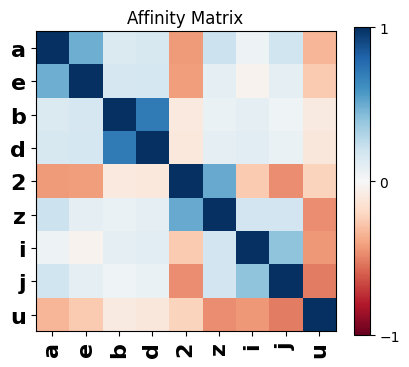

In [70]:
affinity_path = "/Users/mfamili/work/exp_avae/alphanum/affinity.csv"
classes = "aebd2ziju"
classes=list(classes)

lookup = pd.read_csv(affinity_path, header=0)

lookup = lookup.loc[[lookup.columns.get_loc(c) for c in classes if c in lookup],classes]


with plt.rc_context(
    {"font.weight": "bold", "font.size": int(len(classes) / 3) + 3}
):
    fig, ax = plt.subplots(
        figsize=(int(len(classes)) / 2, int(len(classes)) / 2)
    )

ax.set_title("Affinity Matrix")
im = ax.imshow(lookup, vmin=-1, vmax=1, cmap=plt.cm.get_cmap("RdBu"))
ax.set_xticks(np.arange(0, len(classes)))
ax.set_xticklabels(classes)
ax.set_yticks(np.arange(0, len(classes)))
ax.set_yticklabels(classes)

ax.tick_params(axis="x", rotation=90, labelsize=16)
ax.tick_params(axis="y", labelsize=16)

pos = ax.get_position()

# Set the height of the color bar to match the height of the plot
cbar = plt.colorbar(im)
cbar.set_ticks([-1, 0, 1])  # You can customize the ticks as needed

# Adjust the position of the color bar to match the height of the plot
cbar.ax.set_position([pos.x1 - 0.01, pos.y0, 0.02, pos.height-1])

fig.tight_layout()

plt.savefig("affinity.png",dpi=300)


# Plot the cosine similarity of the latent space
Choose from the dropdown menu between plotting the average or the standard deviation of the cosine similarity 

In [71]:
from avae.vis import latent_space_similarity_plot

interact(lambda plot_mode: latent_space_similarity_plot(latent_space= z, class_labels = labels, 
                             classes_order= classes,plot_mode = plot_mode, 
                             display = True, font_size=16, dpi=100), plot_mode=Dropdown(options=["mean", "std"]))



interactive(children=(Dropdown(description='plot_mode', options=('mean', 'std'), value='mean'), Output()), _do…

<function __main__.<lambda>(plot_mode)>

# Plot Rotation Angle-Pose correlation    

This figure takes in an original image and rotates it through a range of angle from `THETA_LOWER` to `THETA_UPPER` and extract the pose value learnt. It then plots the corresponding pose value and the angle of rotation as well as the decoded image grid.

- `img_path`: Input the path of an image from your data 
- `THETA_LOWER`, `THETA_UPPER`: Input the lower and upper range of rotation in degrees

In [79]:
from scipy.ndimage import rotate
from skimage.util import montage 

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

img_path = "/Users/mfamili/Downloads/synth_an_data/j_1392_0_img.npy"
THETA_LOWER = -40
THETA_UPPER = 40
theta_list = np.arange(THETA_LOWER,THETA_UPPER,0.2)
img = NormalizeData(np.load(img_path))

r=[]
original = []
pose_angle=[]

with torch.inference_mode():
    for idx, theta in enumerate(theta_list):
        image = rotate(img, theta, order=0, reshape = False)
        
        x, z, z_pose, mu, logvar = model(torch.from_numpy(image[np.newaxis,np.newaxis, ...]).to(torch.float32))     
        if idx % 5 == 0 : 
            r.append(x.squeeze().detach().numpy())
            original.append(image.squeeze())
        pose_angle.append(z_pose[0,0].cpu().clone().numpy())



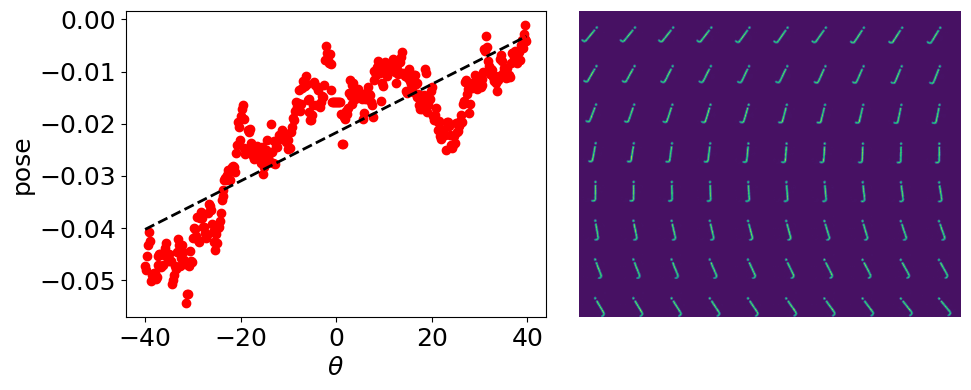

In [80]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax1, ax2 = ax

coef = np.polyfit(theta_list,np.squeeze(pose_angle),1)
poly1d_fn = np.poly1d(coef) 
ax1.plot(theta_list,np.squeeze(pose_angle),'ro',theta_list,poly1d_fn(theta_list),'--k',
    linewidth=2)
ax1.set_xlabel(r'$\theta$', fontsize=18)
ax1.set_ylabel('pose', fontsize=18)
ax1.tick_params(axis='both',labelsize=18)

r = np.stack(r, axis=0)
original = np.stack(original, axis=0,)

num_rows = 10
m = montage(r, grid_shape=( int(len(r)/num_rows), num_rows))
n = montage(original, grid_shape=( int(len(r)/num_rows), num_rows))
ax2.imshow(m)
#ax3.imshow(n)
ax2.axis('off')

fig.tight_layout()
fig.savefig("pose_angle_images.png", dpi=144)